In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
# from azureml.core import Workspace, Dataset

# # Get the current working directory
# current_dir = os.getcwd()

# # Construct the absolute path
# config_path = os.path.join(current_dir, 'config.json')
# print("Absolute path to config.json:", config_path)

# # Use the absolute path in the from_config method
# workspace = Workspace.from_config(path=config_path)
# dataset = Dataset.get_by_name(workspace, name='BiMl')
# dataframe = dataset.to_pandas_dataframe()

In [3]:
df = pd.read_csv('clean_crimes.csv')
df

,DR_NO,Date_Rptd,DATE_OCC,DATE_TIME_OCC,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1_2,Crm_Cd,Crm_Cd_Desc,Mocodes,Vict_Age,Vict_Sex,Vict_Descent,Premis_Cd,Premis_Desc,Weapon_Used_Cd,Weapon_Desc,Status,Status_Desc,Crm_Cd_1,Crm_Cd_2,Crm_Cd_3,Crm_Cd_4,LOCATION,Cross_Street,LAT,LON
0,1307355,2010-02-20,2010-02-20,2010-02-20 13:50:00,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0,48,M,H,501,SINGLE FAMILY DWELLING,0,NaN,AA,Adult Arrest,900,0,0,0,300 E GAGE AV,NaN,33.9825,-118.2695
1,90631215,2010-01-05,2010-01-05,2010-01-05 01:50:00,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,0,47,F,W,101,STREET,102,HAND GUN,IC,Invest Cont,900,998,0,0,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
2,100100501,2010-01-03,2010-01-02,2010-01-02 21:00:00,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",400,47,F,H,103,ALLEY,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,122,0,0,0,8TH ST,SAN PEDRO ST,34.0387,-118.2488
3,100100506,2010-01-05,2010-01-04,2010-01-04 16:50:00,1650,1,Central,162,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),0,23,M,B,404,DEPARTMENT STORE,0,NaN,AA,Adult Arrest,442,0,0,0,700 W 7TH ST,NaN,34.0480,-118.2577
4,100100508,2010-01-08,2010-01-07,2010-01-07 20:05:00,2005,1,Central,182,1,330,BURGLARY FROM VEHICLE,344,46,M,H,101,STREET,0,NaN,IC,Invest Cont,330,0,0,0,PICO BL,GRAND AV,34.0389,-118.2643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2327092,231606525,2023-03-22,2023-03-22,2023-03-22 10:00:00,1000,16,Foothill,1602,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0,25,F,H,102,SIDEWALK,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,230,0,0,0,12800 FILMORE ST,NaN,34.2790,-118.4116
2327093,231210064,2023-04-12,2023-04-12,2023-04-12 16:30:00,1630,12,77th Street,1239,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0,29,M,B,222,LAUNDROMAT,500,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,230,0,0,0,6100 S VERMONT AV,NaN,33.9841,-118.2915
2327094,230115220,2023-07-02,2023-07-01,2023-07-01 00:01:00,1,1,Central,154,1,352,PICKPOCKET,0,24,F,H,735,NIGHT CLUB (OPEN EVENINGS ONLY),0,NaN,IC,Invest Cont,352,0,0,0,500 S MAIN ST,NaN,34.0467,-118.2485
2327095,230906458,2023-03-05,2023-03-05,2023-03-05 09:00:00,900,9,Van Nuys,914,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0,53,F,H,502,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0,NaN,IC,Invest Cont,745,0,0,0,14500 HARTLAND ST,NaN,34.1951,-118.4487


In [4]:
# Assuming df is your DataFrame
data = df.copy()

# Convert 'DATE_TIME_OCC' into datetime objects and extract features
data['DATE_TIME_OCC'] = pd.to_datetime(data['DATE_TIME_OCC'])
data['Month'] = data['DATE_TIME_OCC'].dt.month
data['Hour'] = data['DATE_TIME_OCC'].dt.hour

In [5]:
# Step 2: Find Duplicates
# `keep=False` marks all duplicates as True
duplicates = data.duplicated('DR_NO', keep=False)

# Step 3: Filter Duplicates
duplicates_df = data[duplicates]

# Step 4: Examine Differences
# Sorting by 'DR_NO' to group the duplicates together for easier comparison
sorted_duplicates_df = duplicates_df.sort_values(by='DR_NO')

# Displaying the relevant columns for comparison
sorted_duplicates_df[['DR_NO', 'Part_1_2', 'Crm_Cd', 'Status']]

,DR_NO,Part_1_2,Crm_Cd,Status
801184,211517655,2,903,AA
1891019,211517655,2,903,AA
1937069,211517656,1,230,IC
757888,211517656,1,230,IC
697973,211517657,2,624,IC
...,...,...,...,...
1989953,232116483,2,354,IC
1869630,232117017,2,354,IC
809717,232117017,2,354,IC
1934895,232117502,2,354,IC


In [6]:
data

,DR_NO,Date_Rptd,DATE_OCC,DATE_TIME_OCC,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1_2,Crm_Cd,Crm_Cd_Desc,Mocodes,Vict_Age,Vict_Sex,Vict_Descent,Premis_Cd,Premis_Desc,Weapon_Used_Cd,Weapon_Desc,Status,Status_Desc,Crm_Cd_1,Crm_Cd_2,Crm_Cd_3,Crm_Cd_4,LOCATION,Cross_Street,LAT,LON,Month,Hour
0,1307355,2010-02-20,2010-02-20,2010-02-20 13:50:00,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0,48,M,H,501,SINGLE FAMILY DWELLING,0,NaN,AA,Adult Arrest,900,0,0,0,300 E GAGE AV,NaN,33.9825,-118.2695,2,13
1,90631215,2010-01-05,2010-01-05,2010-01-05 01:50:00,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,0,47,F,W,101,STREET,102,HAND GUN,IC,Invest Cont,900,998,0,0,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,1,1
2,100100501,2010-01-03,2010-01-02,2010-01-02 21:00:00,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",400,47,F,H,103,ALLEY,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,122,0,0,0,8TH ST,SAN PEDRO ST,34.0387,-118.2488,1,21
3,100100506,2010-01-05,2010-01-04,2010-01-04 16:50:00,1650,1,Central,162,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),0,23,M,B,404,DEPARTMENT STORE,0,NaN,AA,Adult Arrest,442,0,0,0,700 W 7TH ST,NaN,34.0480,-118.2577,1,16
4,100100508,2010-01-08,2010-01-07,2010-01-07 20:05:00,2005,1,Central,182,1,330,BURGLARY FROM VEHICLE,344,46,M,H,101,STREET,0,NaN,IC,Invest Cont,330,0,0,0,PICO BL,GRAND AV,34.0389,-118.2643,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2327092,231606525,2023-03-22,2023-03-22,2023-03-22 10:00:00,1000,16,Foothill,1602,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0,25,F,H,102,SIDEWALK,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,230,0,0,0,12800 FILMORE ST,NaN,34.2790,-118.4116,3,10
2327093,231210064,2023-04-12,2023-04-12,2023-04-12 16:30:00,1630,12,77th Street,1239,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0,29,M,B,222,LAUNDROMAT,500,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,230,0,0,0,6100 S VERMONT AV,NaN,33.9841,-118.2915,4,16
2327094,230115220,2023-07-02,2023-07-01,2023-07-01 00:01:00,1,1,Central,154,1,352,PICKPOCKET,0,24,F,H,735,NIGHT CLUB (OPEN EVENINGS ONLY),0,NaN,IC,Invest Cont,352,0,0,0,500 S MAIN ST,NaN,34.0467,-118.2485,7,0
2327095,230906458,2023-03-05,2023-03-05,2023-03-05 09:00:00,900,9,Van Nuys,914,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0,53,F,H,502,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0,NaN,IC,Invest Cont,745,0,0,0,14500 HARTLAND ST,NaN,34.1951,-118.4487,3,9


In [7]:
# def downsample_data(data, target_size=100000, min_occurrences=100):
#     # Ensure random state for reproducibility
#     random_state = 42

#     # Filter out less frequent crimes based on min_occurrences
#     crime_counts = data['Crm_Cd_Desc'].value_counts()
#     frequent_crimes = crime_counts[crime_counts > min_occurrences].index.tolist()
#     data_filtered = data[data['Crm_Cd_Desc'].isin(frequent_crimes)]

#     # Check if filtered data still exceeds the target size
#     if len(data_filtered) > target_size:
#         # If so, downsample the filtered data to the target size
#         return data_filtered.sample(n=target_size, random_state=random_state)
#     else:
#         # If filtered data is less than or equal to the target size, just return it
#         return data_filtered

# # Downsample the dataset with the additional constraint
# data_downsampled = downsample_data(data)

# # Display the new shape of the dataset and some basic info to verify the operation
# print("Downsampled dataset shape:", data_downsampled.shape)
# print("Unique crimes in downsampled dataset:", len(data_downsampled['Crm_Cd_Desc'].unique()))
# data_downsampled

# data = data_downsampled.copy()
# data

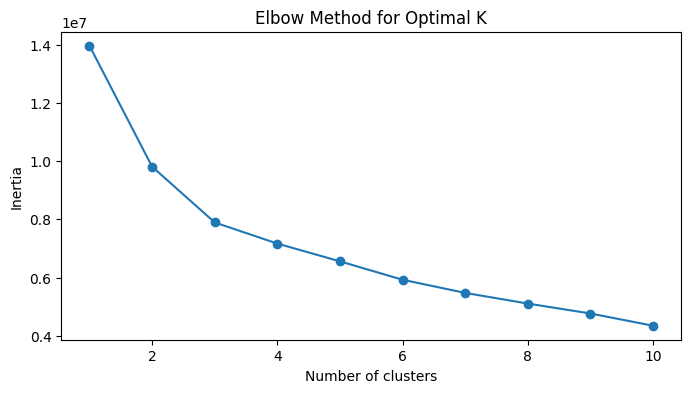

In [8]:
# Categorize into seasons and time of day with both text and numeric
def categorize_season(month):
    if month in [12, 1, 2]: return ('Winter', 0)
    elif month in [3, 4, 5]: return ('Spring', 1)
    elif month in [6, 7, 8]: return ('Summer', 2)
    else: return ('Fall', 3)

data['Season'], data['Season_Code'] = zip(*data['Month'].apply(categorize_season))

# Define numerical and categorical features
numerical_features = ['Season_Code', 'Hour', 'Rpt_Dist_No', 'AREA', 'LON', 'LAT']
# categorical_features = ['Status']


# Create a column transformer to handle preprocessing of different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numerical_features),
        # ('cat', OneHotEncoder(), categorical_features)
    ])

# Apply preprocessing to the features
processed_features = preprocessor.fit_transform(data)

# Determine the optimal number of clusters (K) - Example using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(processed_features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [9]:
# This is an assumption; you should choose K based on the Elbow plot you get
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(processed_features)

# Add the cluster labels to your dataframe
data['Cluster'] = cluster_labels

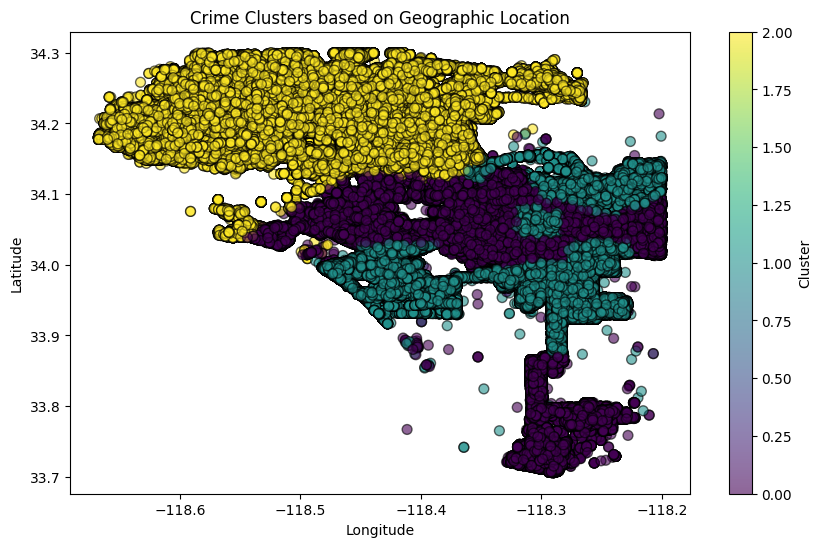

In [10]:
# Visualization of clusters based on LAT and LON
plt.figure(figsize=(10, 6))
plt.scatter(data['LON'], data['LAT'], c=data['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title('Crime Clusters based on Geographic Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

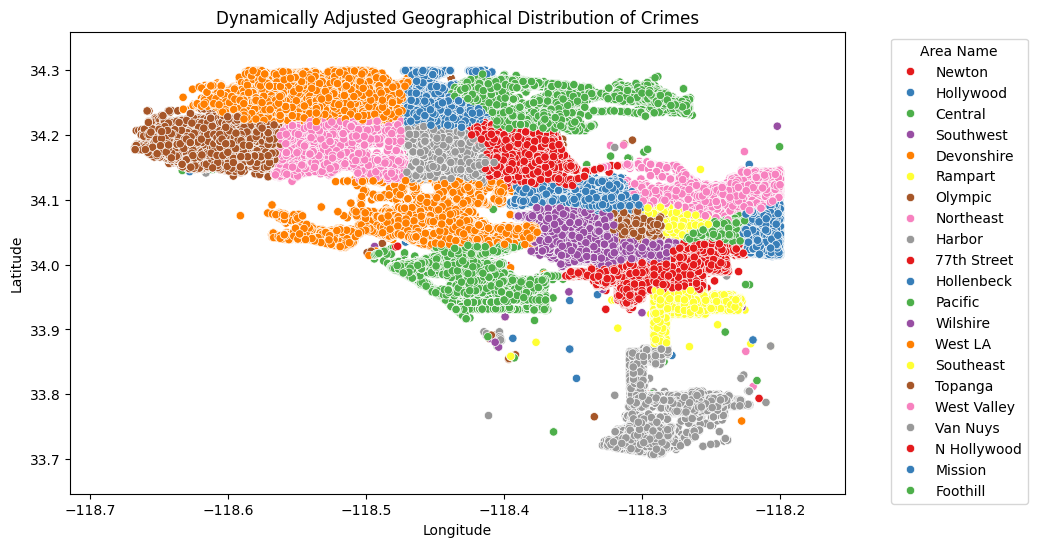

In [11]:
import seaborn as sns

# Calculate the buffer to add beyond the min and max for padding in the plot
lat_buffer = (df['LAT'].max() - df['LAT'].min()) * 0.1
lon_buffer = (df['LON'].max() - df['LON'].min()) * 0.1

# Set the limits for latitude and longitude with the calculated buffer
lat_min, lat_max = df['LAT'].min() - lat_buffer, df['LAT'].max() + lat_buffer
lon_min, lon_max = df['LON'].min() - lon_buffer, df['LON'].max() + lon_buffer

# Visualization: Adjusted Geographical Distribution of Crimes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LON', y='LAT', data=df, hue='AREA_NAME', palette='Set1')

# Set the title and labels
plt.title('Dynamically Adjusted Geographical Distribution of Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust the scales for better clarity
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

# Place the legend outside the plot
plt.legend(title='Area Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [12]:
# # Assuming 'data' is your original DataFrame
# sample_data = data.sample(n=10000)  # Change n=50 to the desired sample size

# # Now you can save this sample to a CSV file
# sample_data.to_csv('sample_data.csv', index=False)

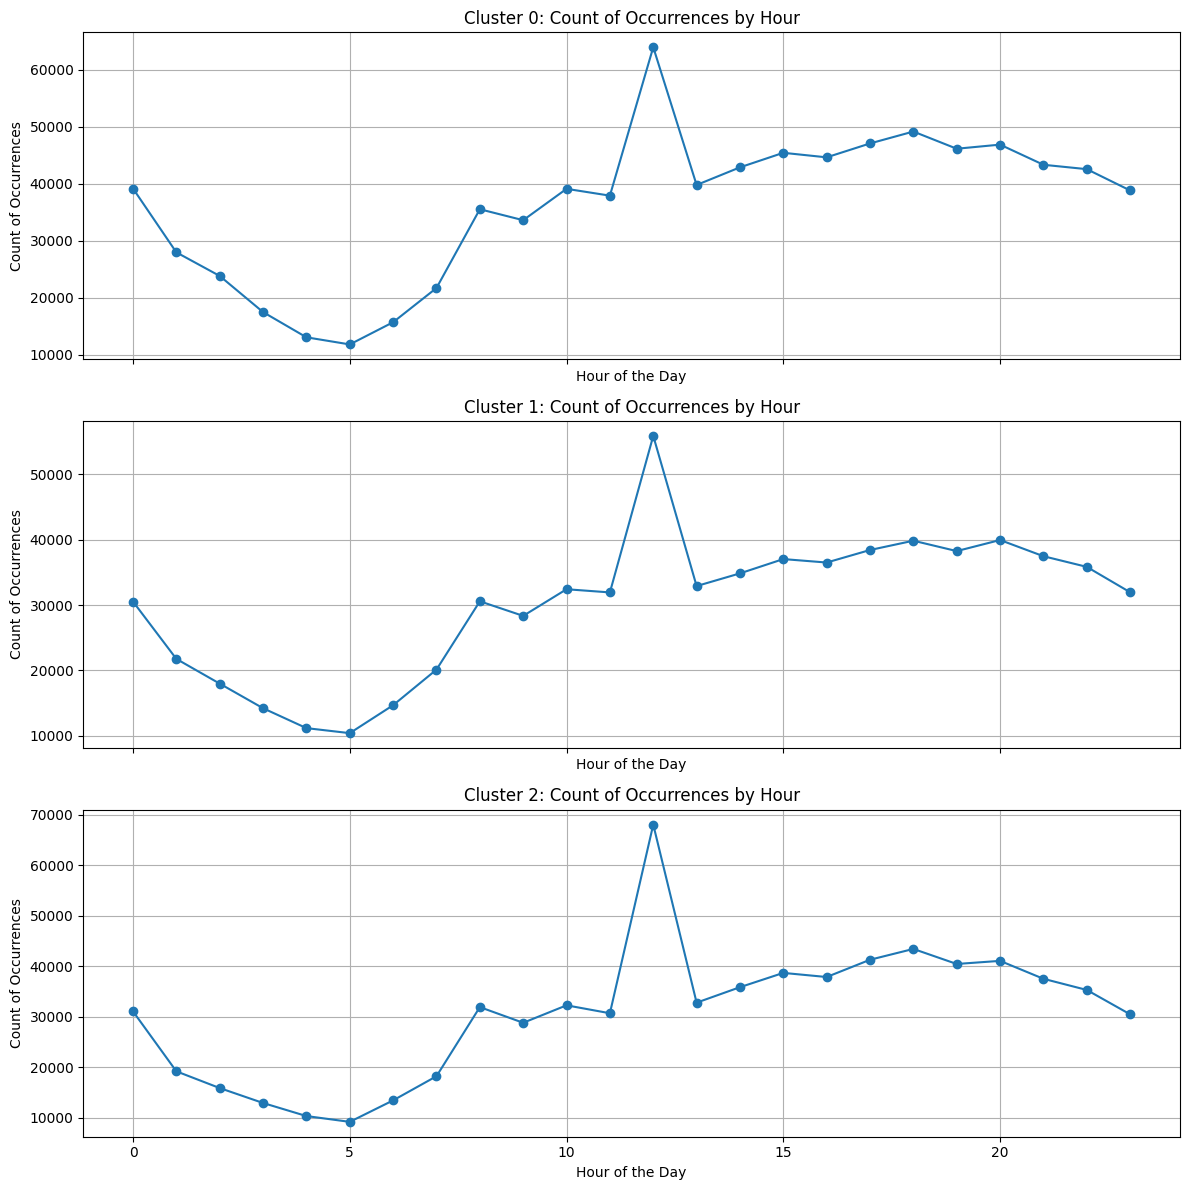

In [13]:
# Determine the number of unique clusters
n_clusters = data['Cluster'].nunique()

# Create subplots - one row for each cluster
fig, axs = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 4), sharex=True)

# Iterate over each cluster to plot
for idx, cluster in enumerate(sorted(data['Cluster'].unique())):
    subset = data[data['Cluster'] == cluster]
    hourly_count = subset.groupby('Hour').size()
    
    # Plot on the respective subplot
    axs[idx].plot(hourly_count.index, hourly_count.values, marker='o', linestyle='-')
    axs[idx].set_title(f'Cluster {cluster}: Count of Occurrences by Hour')
    axs[idx].set_xlabel('Hour of the Day')
    axs[idx].set_ylabel('Count of Occurrences')
    axs[idx].grid(True)

# Improve layout and display the plot
plt.tight_layout()
plt.show()


In [14]:
from shapely.geometry import Point
from shapely.ops import unary_union

# Group the data by the RPD_DIST and then aggregate the lon and lat points
grouped = data.groupby('Rpt_Dist_No').agg(
    centroid_lon=('LON', 'mean'),
    centroid_lat=('LAT', 'mean')
).reset_index()

# Check the result
print(grouped[['Rpt_Dist_No', 'centroid_lon', 'centroid_lat']])


      Rpt_Dist_No  centroid_lon  centroid_lat
0             100   -118.249027     34.043936
1             101   -118.247016     34.067714
2             105   -118.232264     34.070572
3             109   -118.228071     34.073765
4             111   -118.241779     34.060989
...           ...           ...           ...
1273         2189   -118.577668     34.167455
1274         2196   -118.594809     34.151664
1275         2197   -118.572295     34.155268
1276         2198   -118.601877     34.146821
1277         2199   -118.571000     34.135600

[1278 rows x 3 columns]


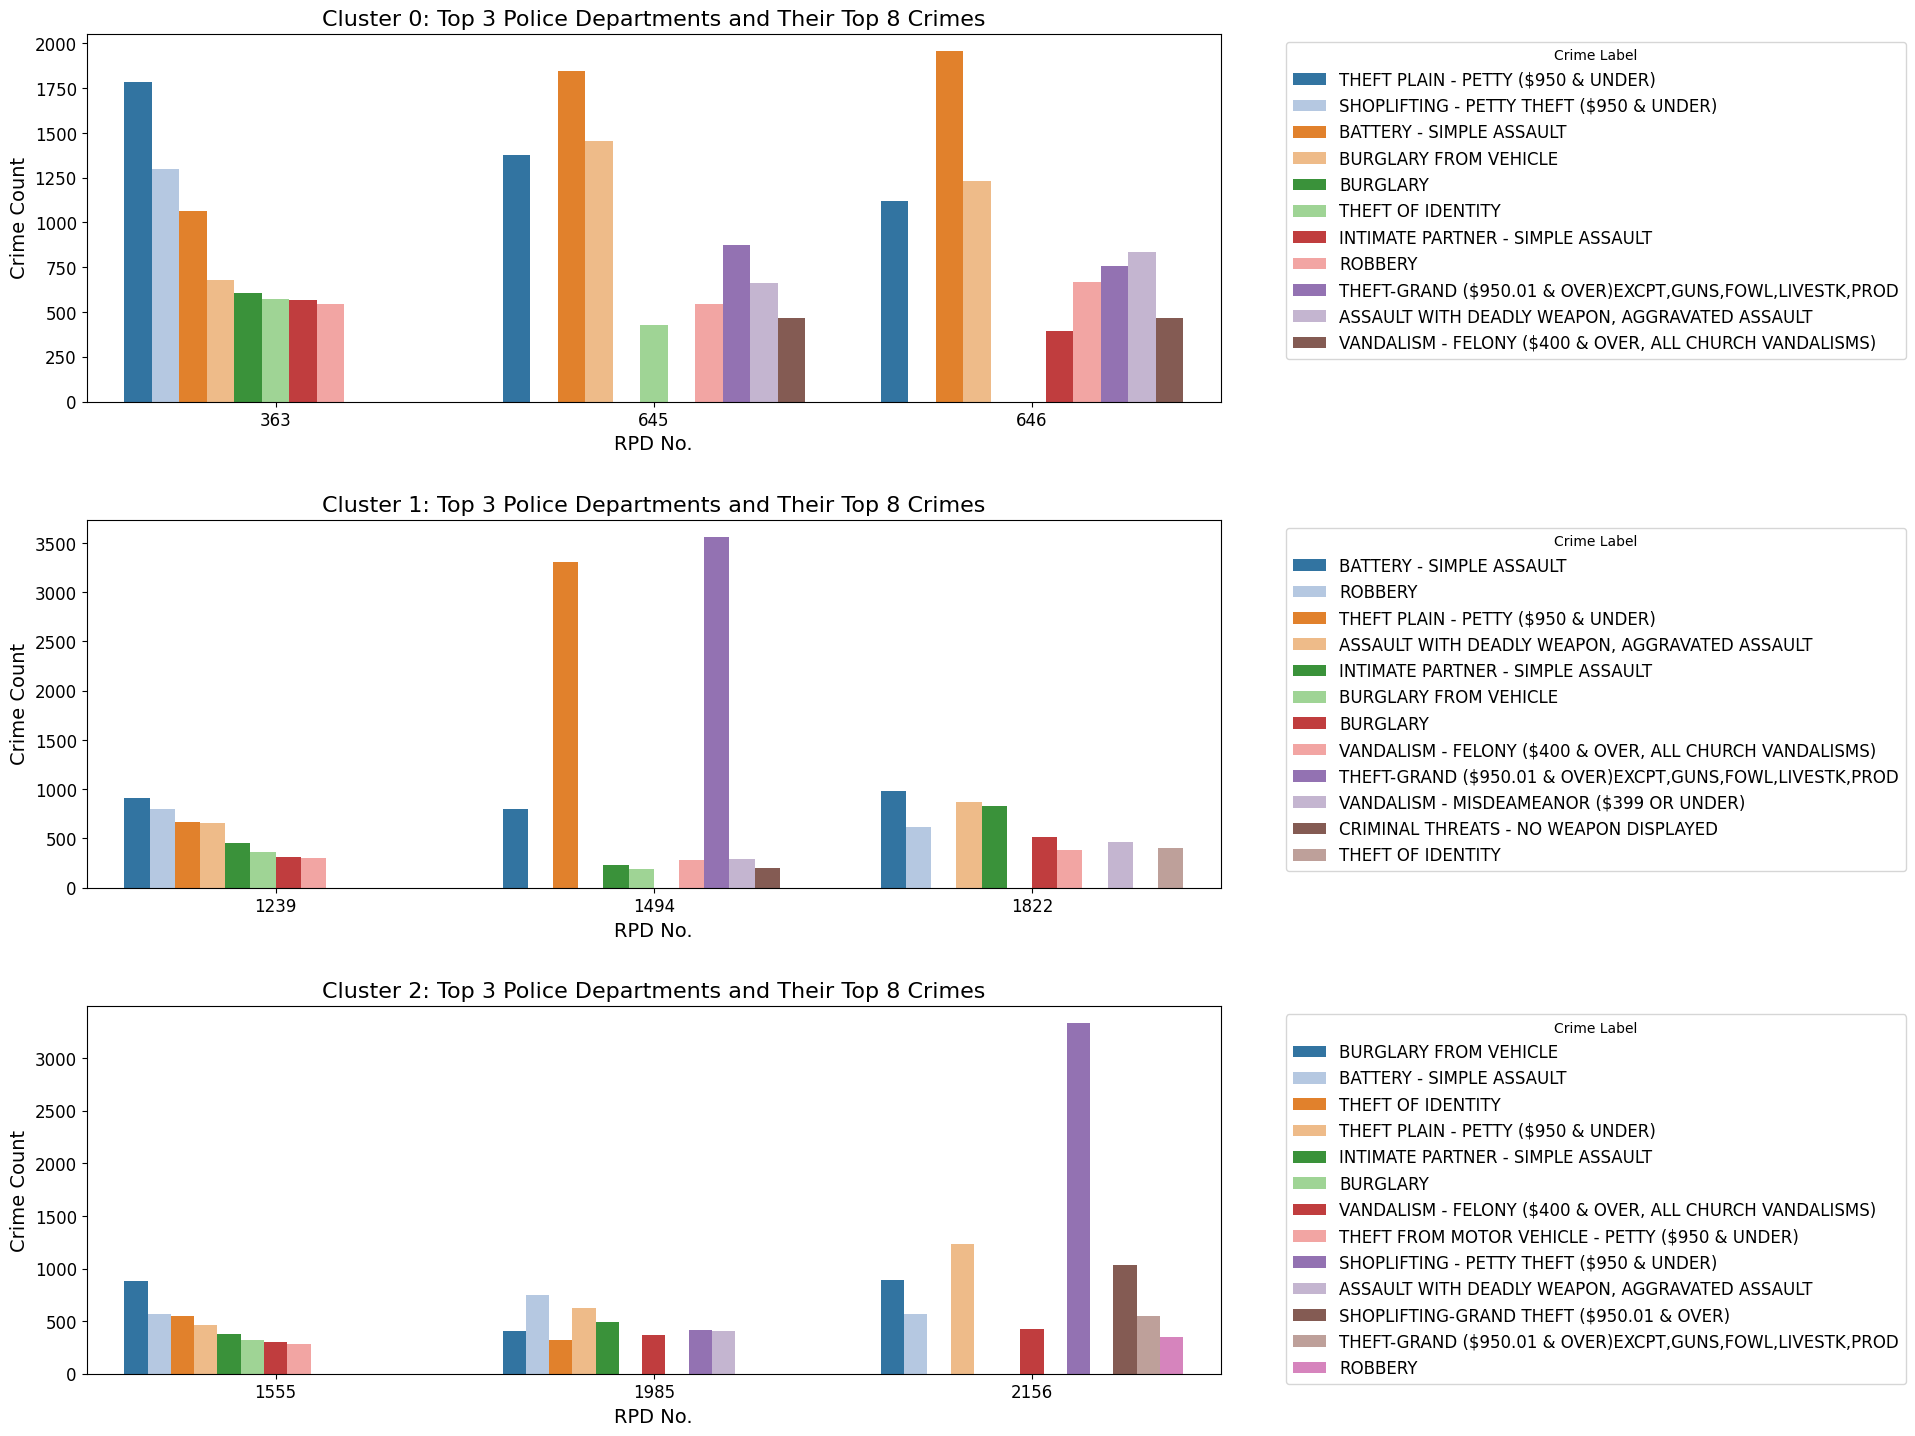

In [15]:
# Assuming 'data' is your DataFrame
# Step 1: Calculate crime counts by cluster, police department, and crime label
crime_counts = data.groupby(['Cluster', 'Rpt_Dist_No', 'Crm_Cd_Desc']).size().reset_index(name='Crime_Count')

# Step 2: Identify the top 3 departments in each cluster based on overall crime counts
top_depts = crime_counts.groupby(['Cluster', 'Rpt_Dist_No'])['Crime_Count'].sum().reset_index()
top_3_depts = top_depts.groupby('Cluster').apply(lambda x: x.nlargest(3, 'Crime_Count')).reset_index(drop=True)

# Step 3: Filter for top crimes in these top 3 departments
top_crimes = crime_counts[crime_counts.set_index(['Cluster', 'Rpt_Dist_No']).index.isin(top_3_depts.set_index(['Cluster', 'Rpt_Dist_No']).index)]
top_crimes = top_crimes.sort_values(['Cluster', 'Rpt_Dist_No', 'Crime_Count'], ascending=[True, True, False])

# Step 4: Limit to top 8 crimes for each department in each cluster
top_8_crimes_per_dept = top_crimes.groupby(['Cluster', 'Rpt_Dist_No']).apply(lambda x: x.nlargest(8, 'Crime_Count')).reset_index(drop=True)

# Step 5: Visualization enhancements
plt.figure(figsize=(20, 15))  # Adjusted figure size for better visibility and to accommodate more categories

for cluster in top_8_crimes_per_dept['Cluster'].unique():
    cluster_data = top_8_crimes_per_dept[top_8_crimes_per_dept['Cluster'] == cluster]
    plt.subplot(len(top_8_crimes_per_dept['Cluster'].unique()), 1, cluster + 1)
    
    sns.barplot(x='Rpt_Dist_No', y='Crime_Count', hue='Crm_Cd_Desc', data=cluster_data, palette='tab20')
    
    plt.title(f'Cluster {cluster}: Top 3 Police Departments and Their Top 8 Crimes', fontsize=16)
    plt.xlabel('RPD No.', fontsize=14)
    plt.ylabel('Crime Count', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Crime Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout(pad=3.0)  # Adjust layout to prevent overlapping and improve readability
plt.show()


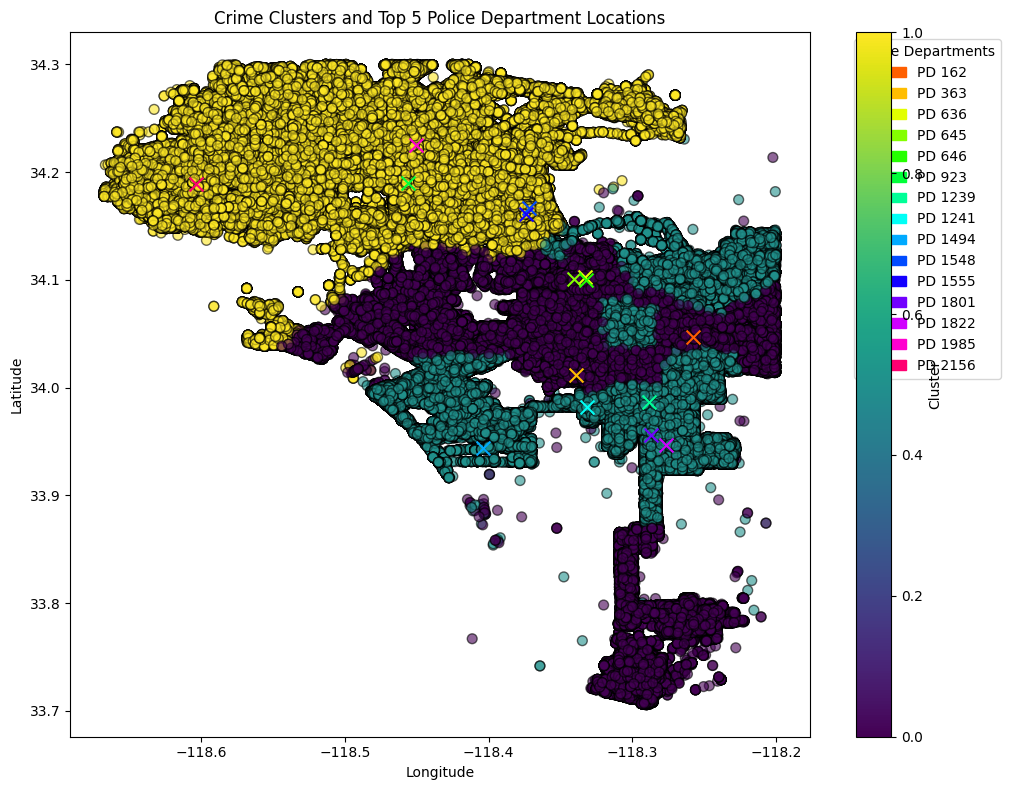

In [16]:
import matplotlib.patches as mpatches

# Step 1: Calculate crime counts by cluster and police department
crime_counts = data.groupby(['Cluster', 'Rpt_Dist_No']).size().reset_index(name='Crime_Count')

# Step 2: Identify the top 5 departments in each cluster based on overall crime counts
top_5_depts = crime_counts.groupby('Cluster').apply(lambda x: x.nlargest(5, 'Crime_Count')).reset_index(drop=True)

# Step 3: Obtain the centroids for these top 5 departments
# Assuming 'grouped' DataFrame contains centroids for all departments, filter for top 5
top_5_centroids = grouped[grouped['Rpt_Dist_No'].isin(top_5_depts['Rpt_Dist_No'])]

# Create a unique color for each Police Department ID
unique_dept_ids = top_5_centroids['Rpt_Dist_No'].unique()
color_palette = sns.color_palette("hsv", len(unique_dept_ids))
dept_colors = {dept_id: color for dept_id, color in zip(unique_dept_ids, color_palette)}

# Plotting the crimes with cluster coloring
plt.figure(figsize=(12, 8))
plt.scatter(data['LON'], data['LAT'], c=data['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6, label='Crimes')

# Overlaying the top 5 police department centroids with unique colors
for index, row in top_5_centroids.iterrows():
    dept_color = dept_colors[row['Rpt_Dist_No']]
    plt.scatter(row['centroid_lon'], row['centroid_lat'], color=dept_color, marker='x', s=100)

# Customizing the plot
plt.title('Crime Clusters and Top 5 Police Department Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')

# Creating custom legend for Police Departments
legend_handles = [mpatches.Patch(color=dept_colors[dept_id], label=f'PD {dept_id}') for dept_id in unique_dept_ids]
plt.legend(handles=legend_handles, title="Police Departments", bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot with the legend outside the plot area
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend
plt.show()

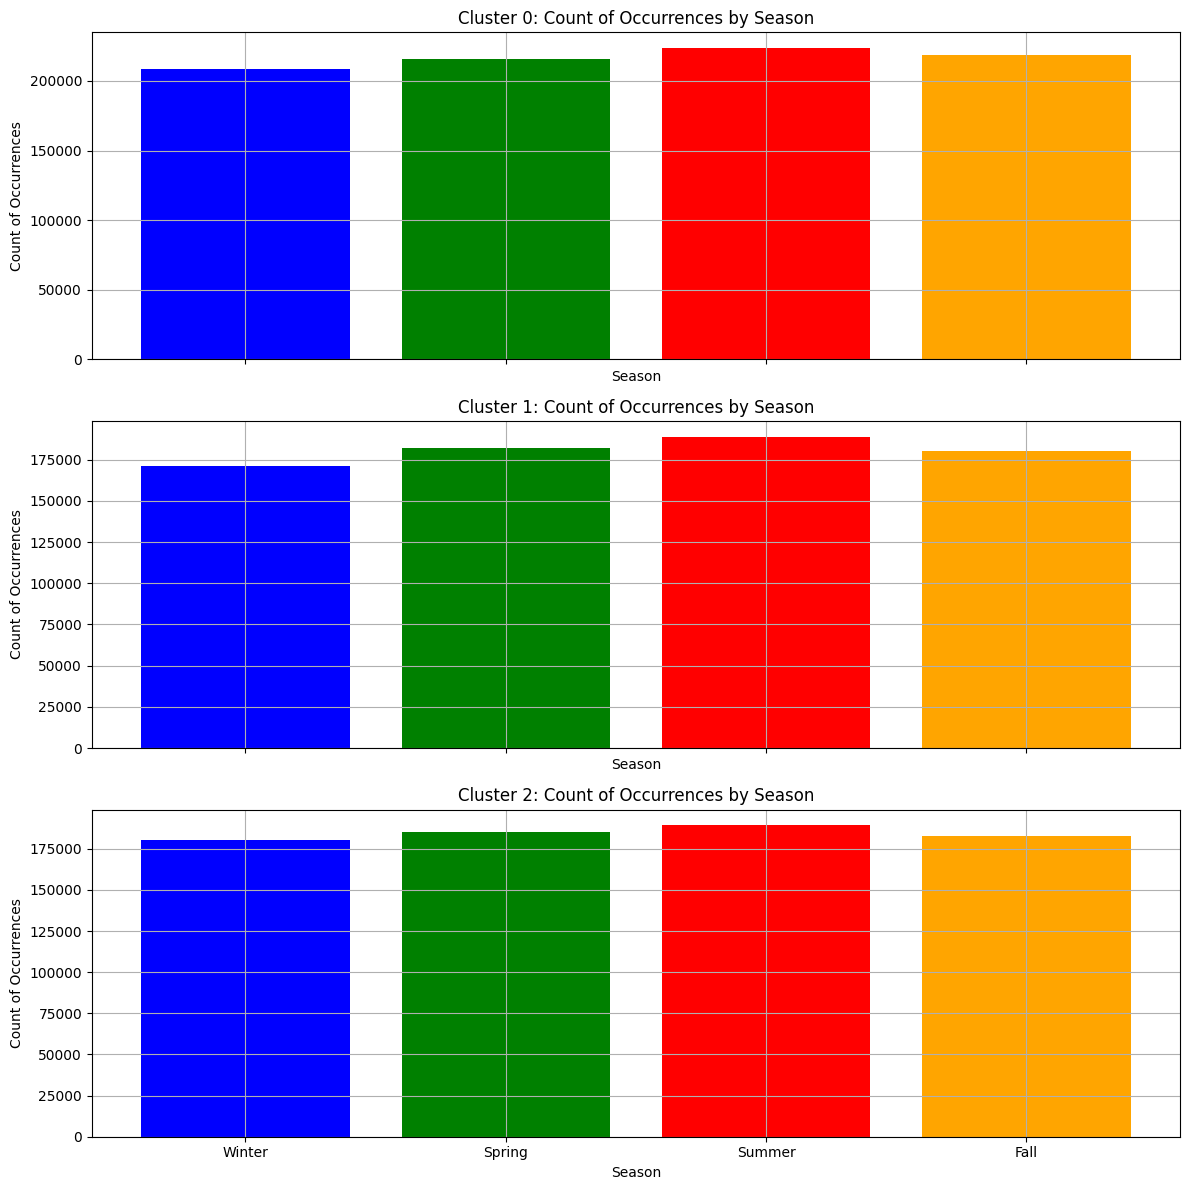

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define a mapping from season codes to season names for plotting
season_code_to_name = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Fall'}

# Determine the number of unique clusters
n_clusters = data['Cluster'].nunique()

# Create subplots - one row for each cluster
fig, axs = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 4), sharex=True)

# Sort season codes for consistent x-axis order
sorted_season_codes = sorted(season_code_to_name.keys())

# Iterate over each cluster to plot
for idx, cluster in enumerate(sorted(data['Cluster'].unique())):
    subset = data[data['Cluster'] == cluster]
    
    # Group by `Season_Code` and count occurrences
    season_code_count = subset.groupby('Season_Code').size().reindex(sorted_season_codes)
    
    # Convert season codes to season names for plotting
    season_names = [season_code_to_name[code] for code in season_code_count.index]
    
    # Plot on the respective subplot
    axs[idx].bar(season_names, season_code_count.values, color=['blue', 'green', 'red', 'orange'])
    axs[idx].set_title(f'Cluster {cluster}: Count of Occurrences by Season')
    axs[idx].set_xlabel('Season')
    axs[idx].set_ylabel('Count of Occurrences')
    axs[idx].grid(True)

# Improve layout and display the plot
plt.tight_layout()
plt.show()


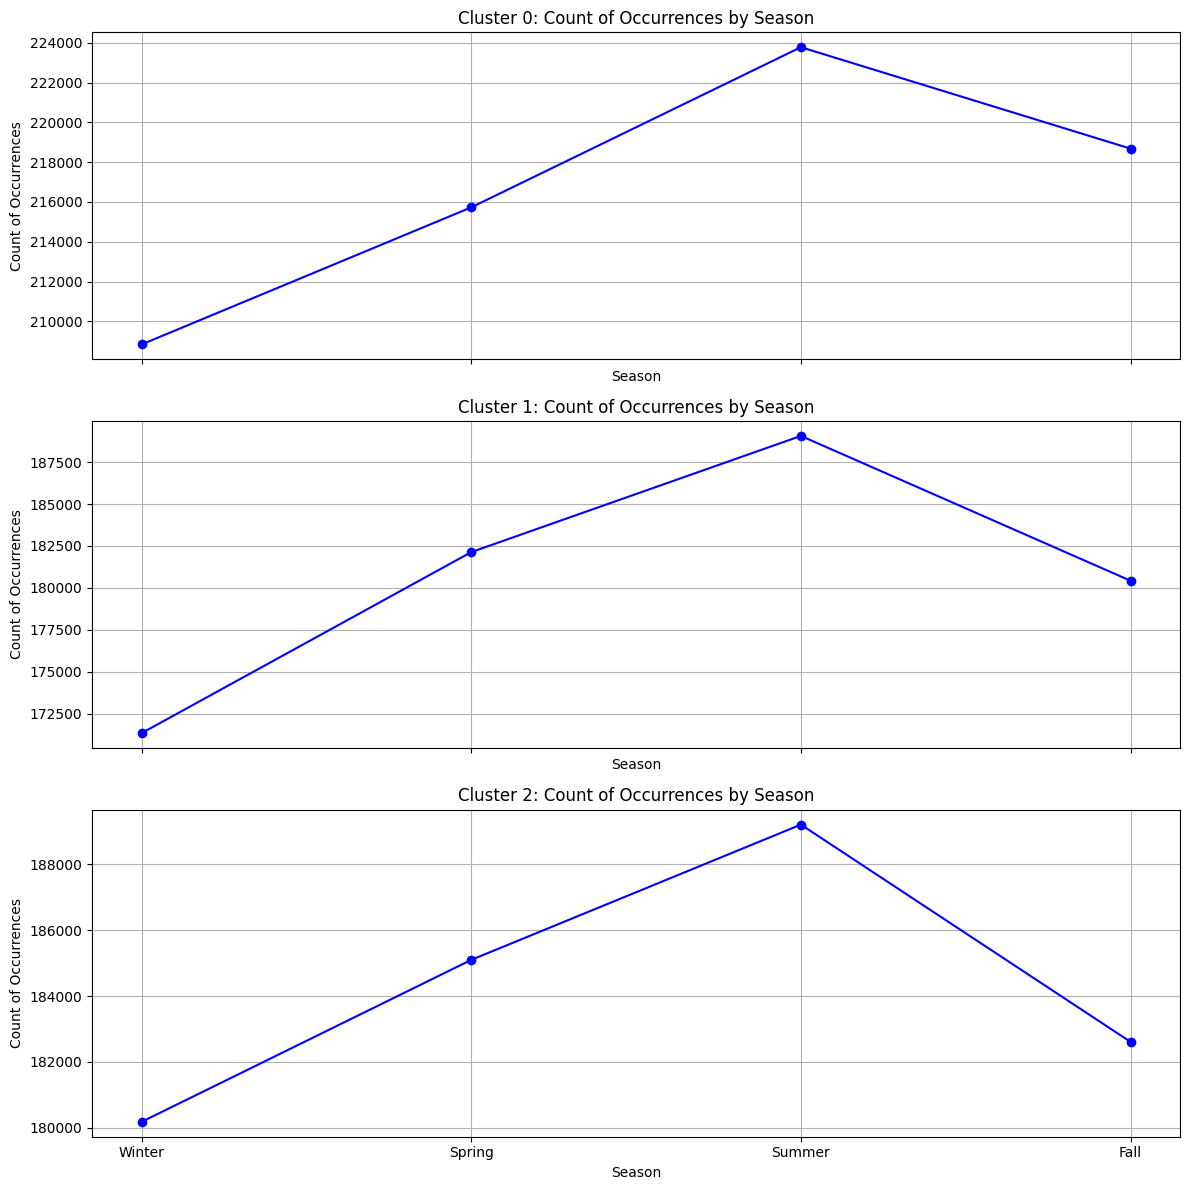

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define a mapping from season codes to season names for plotting
season_code_to_name = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Fall'}

# Determine the number of unique clusters
n_clusters = data['Cluster'].nunique()

# Create subplots - one row for each cluster
fig, axs = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 4), sharex=True)

# Sort season codes for consistent x-axis order
sorted_season_codes = sorted(season_code_to_name.keys())
sorted_season_names = [season_code_to_name[code] for code in sorted_season_codes]

# Iterate over each cluster to plot
for idx, cluster in enumerate(sorted(data['Cluster'].unique())):
    subset = data[data['Cluster'] == cluster]
    
    # Group by `Season_Code` and count occurrences
    season_code_count = subset.groupby('Season_Code').size().reindex(sorted_season_codes)
    
    # Plot on the respective subplot
    axs[idx].plot(sorted_season_names, season_code_count.values, marker='o', linestyle='-', color='blue')
    axs[idx].set_title(f'Cluster {cluster}: Count of Occurrences by Season')
    axs[idx].set_xlabel('Season')
    axs[idx].set_ylabel('Count of Occurrences')
    axs[idx].grid(True)

# Improve layout and display the plot
plt.tight_layout()
plt.show()


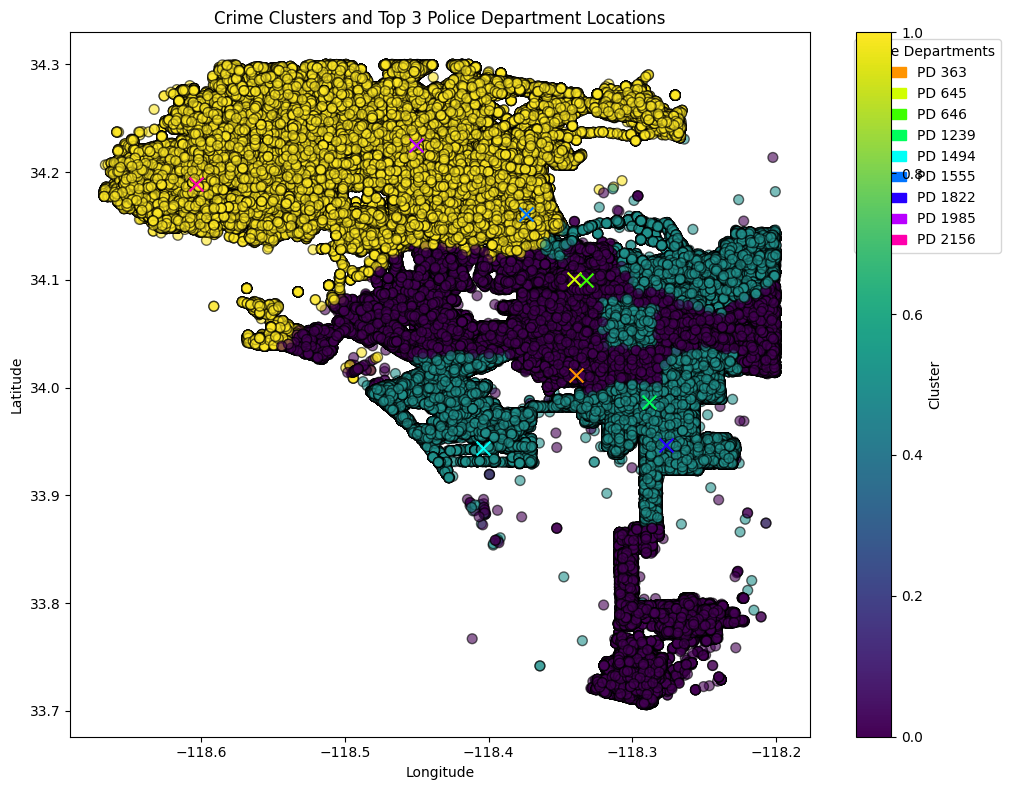

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Step 1: Calculate crime counts by cluster and police department
crime_counts = data.groupby(['Cluster', 'Rpt_Dist_No']).size().reset_index(name='Crime_Count')

# Identify the top 3 departments in each cluster based on overall crime counts
top_3_depts = crime_counts.groupby('Cluster').apply(lambda x: x.nlargest(3, 'Crime_Count')).reset_index(drop=True)

# Step 3: Obtain the centroids for these top 3 departments
# Assuming 'grouped' DataFrame contains centroids for all departments, filter for top 3
top_3_centroids = grouped[grouped['Rpt_Dist_No'].isin(top_3_depts['Rpt_Dist_No'])]

# Create a unique color for each Police Department ID
unique_dept_ids = top_3_centroids['Rpt_Dist_No'].unique()
color_palette = sns.color_palette("hsv", len(unique_dept_ids))
dept_colors = {dept_id: color for dept_id, color in zip(unique_dept_ids, color_palette)}

# Plotting the crimes with cluster coloring
plt.figure(figsize=(12, 8))
plt.scatter(data['LON'], data['LAT'], c=data['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6, label='Crimes')

# Overlaying the top 3 police department centroids with unique colors
for index, row in top_3_centroids.iterrows():
    dept_color = dept_colors[row['Rpt_Dist_No']]
    plt.scatter(row['centroid_lon'], row['centroid_lat'], color=dept_color, marker='x', s=100)

# Customizing the plot
plt.title('Crime Clusters and Top 3 Police Department Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')

# Creating custom legend for Police Departments
legend_handles = [mpatches.Patch(color=dept_colors[dept_id], label=f'PD {dept_id}') for dept_id in unique_dept_ids]
plt.legend(handles=legend_handles, title="Police Departments", bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot with the legend outside the plot area
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend
plt.show()


In [20]:
# List of area codes of interest
areas_of_interest = [1, 20, 18]

# Filtering the DataFrame to include only the rows where the AREA is in the areas_of_interest list
area_names = data.loc[data['AREA'].isin(areas_of_interest), ['AREA', 'AREA_NAME']].drop_duplicates()

# Displaying the result
print(area_names)


       AREA  AREA_NAME
2         1    Central
7315     20    Olympic
18614    18  Southeast
